# Imports

In [1]:
!pip install pykan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 1.6 MB/s eta 0:00:00


In [19]:
# from kan import *
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from typing import *
import math

# pykan

In [8]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  test_size=0.99,
                                                  stratify=y_train,
                                                  random_state=42)
x_test, _, y_test, _ = train_test_split(x_test,
                                        y_test,
                                        test_size=0.99,
                                        stratify=y_test,
                                        random_state=42)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((600, 28, 28), (600,), (100, 28, 28), (100,))

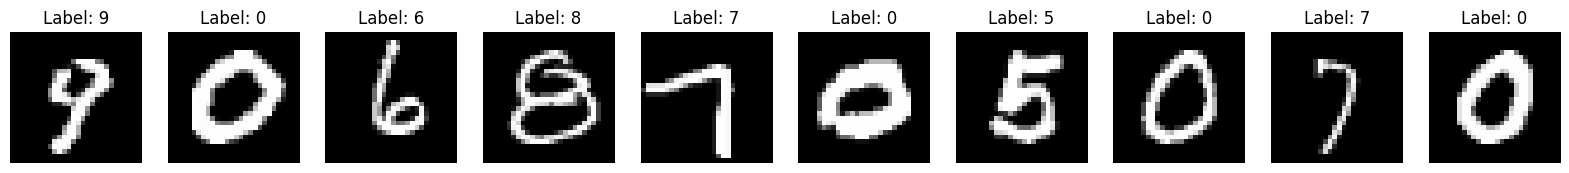

In [9]:
num_samples = 10

# Plotting the samples
plt.figure(figsize=(20, 2))

for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')

plt.show()

In [10]:
# Desired new size
new_size = (14, 14)

# Function to resize images
def resize_images(images, size):
    resized_images = []
    for img in images:
        img_resized = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
        resized_images.append(img_resized)
    return np.array(resized_images)

# Resize training and test images
x_train = resize_images(x_train, new_size)
x_test = resize_images(x_test, new_size)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((600, 14, 14), (600,), (100, 14, 14), (100,))

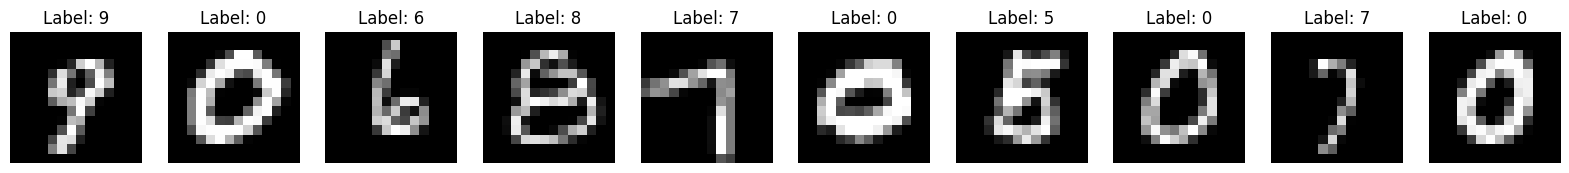

In [11]:
num_samples = 10

# Plotting the samples
plt.figure(figsize=(20, 2))

for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')

plt.show()

In [12]:
# Normalize the images and divide by 255
x_train_normalized = x_train / 255.0
x_test_normalized = x_test / 255.0

# Flatten the images
x_train_flattened = x_train_normalized.reshape((x_train_normalized.shape[0], -1))
x_test_flattened = x_test_normalized.reshape((x_test_normalized.shape[0], -1))

x_train_flattened.shape, y_train.shape, x_test_flattened.shape, y_test.shape

((600, 196), (600,), (100, 196), (100,))

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
# Convert to PyTorch tensors
train_input_tensor = torch.tensor(x_train_flattened, dtype=torch.float64).to(device)
test_input_tensor = torch.tensor(x_test_flattened, dtype=torch.float64).to(device)
train_label_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
test_label_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Create the dataset dictionary
dataset = {
    'train_input': train_input_tensor,
    'test_input': test_input_tensor,
    'train_label': train_label_tensor,
    'test_label': test_label_tensor
}

## Model and Train

In [14]:
def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float()).to(device)

torch.set_default_dtype(torch.float64)

model = KAN(width=[x_train_flattened.shape[-1],10], grid=3, k=3, ).to(device)

results = model.train(dataset, opt="LBFGS", steps=50, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss(), device =device );


# grids = [5,10,20,50,100,500]

# train_rmse = []
# test_rmse = []

# for i in range(len(grids)):
#     model = KAN(width=[x_train_flattened.shape[-1],10], grid=grids[i], k=3, seed=0).initialize_from_another_model(model, dataset['train_input'])
#     results = model.train(dataset, opt="LBFGS", steps=50, stop_grid_update_step=30);
#     train_rmse.append(results['train_loss'][-1].item())
#     test_rmse.append(results['test_loss'][-1].item())

Directory already exists: ./model


train loss: 2.28e-09 | test loss: 2.91e+00 | reg: 1.13e+04 :  10%|▎  | 5/50 [02:02<18:22, 24.50s/it]


RuntimeError: false INTERNAL ASSERT FAILED at "../aten/src/ATen/native/BatchLinearAlgebra.cpp":1537, please report a bug to PyTorch. torch.linalg.lstsq: (Batch element 0): Argument 4 has illegal value. Most certainly there is a bug in the implementation calling the backend library.

# Efficient KAN

## Model

In [17]:
import torch
import torch.nn.functional as F
import math


class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.reshape(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output

        output = output.reshape(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class EfficientKAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

## Train


In [ ]:
IMG_SIZE = 14

# Load MNIST
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Resize((IMG_SIZE, IMG_SIZE))]
)
trainset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
valset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
trainloader = DataLoader(trainset, batch_size=1024, shuffle=True)
valloader = DataLoader(valset, batch_size=1024 * 16, shuffle=False)

# Define model
model = EfficientKAN([IMG_SIZE ** 2, 10])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

# Define loss
criterion = nn.CrossEntropyLoss()

# Lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(100):
    # Train
    model.train()
    running_loss = 0
    running_accuracy = 0
    with tqdm(trainloader) as pbar:
        for i, (images, labels) in enumerate(pbar):
            images = images.view(-1, IMG_SIZE**2 ).to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels.to(device))
            loss.backward()
            optimizer.step()
            accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
            running_loss += loss.item()
            running_accuracy += accuracy.item()
            pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])

    train_loss = running_loss / len(trainloader)
    train_accuracy = running_accuracy / len(trainloader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for images, labels in valloader:
            images = images.view(-1, IMG_SIZE**2).to(device)
            output = model(images)
            val_loss += criterion(output, labels.to(device)).item()
            val_accuracy += (
                (output.argmax(dim=1) == labels.to(device)).float().mean().item()
            )
    val_loss /= len(valloader)
    val_accuracy /= len(valloader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Update learning rate
    scheduler.step(val_loss)

    print(
        f"Epoch {epoch + 1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}"
    )



100%|██████████| 59/59 [00:12<00:00,  4.65it/s, accuracy=0.727, loss=1.78, lr=0.001]


Epoch 1, Train Loss: 2.041449334661839, Train Accuracy: 0.5597759050838018, Val Loss: 1.7559857368469238, Val Accuracy: 0.7476999759674072


100%|██████████| 59/59 [00:13<00:00,  4.45it/s, accuracy=0.822, loss=1.22, lr=0.001]


Epoch 2, Train Loss: 1.4928487175602023, Train Accuracy: 0.7698309270002074, Val Loss: 1.2091498374938965, Val Accuracy: 0.814799964427948


100%|██████████| 59/59 [00:12<00:00,  4.55it/s, accuracy=0.829, loss=0.851, lr=0.001]


Epoch 3, Train Loss: 1.0332886051323453, Train Accuracy: 0.8166022593692198, Val Loss: 0.8431289792060852, Val Accuracy: 0.8460999727249146


100%|██████████| 59/59 [00:12<00:00,  4.56it/s, accuracy=0.854, loss=0.67, lr=0.001]


Epoch 4, Train Loss: 0.7562961174269854, Train Accuracy: 0.8486180032713938, Val Loss: 0.6398264169692993, Val Accuracy: 0.864799976348877


100%|██████████| 59/59 [00:12<00:00,  4.62it/s, accuracy=0.888, loss=0.545, lr=0.001]


Epoch 5, Train Loss: 0.5998908624810687, Train Accuracy: 0.8685857007059, Val Loss: 0.5232707262039185, Val Accuracy: 0.8816999793052673


100%|██████████| 59/59 [00:13<00:00,  4.54it/s, accuracy=0.896, loss=0.462, lr=0.001]


Epoch 6, Train Loss: 0.5058559502585459, Train Accuracy: 0.881370741431996, Val Loss: 0.45007777214050293, Val Accuracy: 0.8946999907493591


100%|██████████| 59/59 [00:12<00:00,  4.56it/s, accuracy=0.895, loss=0.431, lr=0.001]


Epoch 7, Train Loss: 0.4451657791258925, Train Accuracy: 0.8906946919732175, Val Loss: 0.4015207886695862, Val Accuracy: 0.901699960231781


100%|██████████| 59/59 [00:12<00:00,  4.61it/s, accuracy=0.89, loss=0.403, lr=0.001]


Epoch 8, Train Loss: 0.4031809229971999, Train Accuracy: 0.8982911463511192, Val Loss: 0.36747437715530396, Val Accuracy: 0.9068999886512756


100%|██████████| 59/59 [00:12<00:00,  4.69it/s, accuracy=0.921, loss=0.33, lr=0.001]


Epoch 9, Train Loss: 0.372575100700734, Train Accuracy: 0.9034056855460345, Val Loss: 0.3432692289352417, Val Accuracy: 0.9101999998092651


100%|██████████| 59/59 [00:12<00:00,  4.55it/s, accuracy=0.916, loss=0.304, lr=0.001]


Epoch 10, Train Loss: 0.34962356747206996, Train Accuracy: 0.9080062447968176, Val Loss: 0.3236671984195709, Val Accuracy: 0.913599967956543


100%|██████████| 59/59 [00:12<00:00,  4.60it/s, accuracy=0.929, loss=0.321, lr=0.001]


Epoch 11, Train Loss: 0.331815396830187, Train Accuracy: 0.9115230895705142, Val Loss: 0.30890920758247375, Val Accuracy: 0.9177999496459961


100%|██████████| 59/59 [00:12<00:00,  4.64it/s, accuracy=0.919, loss=0.28, lr=0.001]


Epoch 12, Train Loss: 0.31759850301985015, Train Accuracy: 0.9139213733753916, Val Loss: 0.29710811376571655, Val Accuracy: 0.9202999472618103


100%|██████████| 59/59 [00:12<00:00,  4.65it/s, accuracy=0.916, loss=0.275, lr=0.001]


Epoch 13, Train Loss: 0.30564019538588444, Train Accuracy: 0.9161332310256312, Val Loss: 0.2876334488391876, Val Accuracy: 0.9217000007629395


100%|██████████| 59/59 [00:12<00:00,  4.65it/s, accuracy=0.929, loss=0.294, lr=0.001]


Epoch 14, Train Loss: 0.29590256865751946, Train Accuracy: 0.9190376552484804, Val Loss: 0.2790153920650482, Val Accuracy: 0.9231999516487122


100%|██████████| 59/59 [00:12<00:00,  4.66it/s, accuracy=0.938, loss=0.224, lr=0.001]


Epoch 15, Train Loss: 0.28730771652722764, Train Accuracy: 0.9204184322033898, Val Loss: 0.2723753750324249, Val Accuracy: 0.924299955368042


100%|██████████| 59/59 [00:12<00:00,  4.63it/s, accuracy=0.918, loss=0.296, lr=0.001]


Epoch 16, Train Loss: 0.28050234231908444, Train Accuracy: 0.9219542751877995, Val Loss: 0.2666015326976776, Val Accuracy: 0.9253000020980835


100%|██████████| 59/59 [00:12<00:00,  4.62it/s, accuracy=0.926, loss=0.288, lr=0.001]


Epoch 17, Train Loss: 0.2742718857223705, Train Accuracy: 0.9234509154901667, Val Loss: 0.26185256242752075, Val Accuracy: 0.9266999959945679


100%|██████████| 59/59 [00:12<00:00,  4.60it/s, accuracy=0.947, loss=0.246, lr=0.001]


Epoch 18, Train Loss: 0.268152183142759, Train Accuracy: 0.9249885011527498, Val Loss: 0.25732913613319397, Val Accuracy: 0.9280999898910522


100%|██████████| 59/59 [00:12<00:00,  4.61it/s, accuracy=0.91, loss=0.311, lr=0.001]


Epoch 19, Train Loss: 0.263705122016244, Train Accuracy: 0.925737692137896, Val Loss: 0.2538740336894989, Val Accuracy: 0.9294999837875366


100%|██████████| 59/59 [00:12<00:00,  4.65it/s, accuracy=0.942, loss=0.209, lr=0.001]


Epoch 20, Train Loss: 0.25859764268842794, Train Accuracy: 0.9271559290966745, Val Loss: 0.25068098306655884, Val Accuracy: 0.9305999875068665


100%|██████████| 59/59 [00:12<00:00,  4.61it/s, accuracy=0.929, loss=0.294, lr=0.001]


Epoch 21, Train Loss: 0.2552166654396865, Train Accuracy: 0.9282405154179718, Val Loss: 0.24693693220615387, Val Accuracy: 0.9310999512672424


100%|██████████| 59/59 [00:12<00:00,  4.65it/s, accuracy=0.929, loss=0.238, lr=0.001]


Epoch 22, Train Loss: 0.25103475102933787, Train Accuracy: 0.9290019031298362, Val Loss: 0.24521130323410034, Val Accuracy: 0.9322999715805054


100%|██████████| 59/59 [00:14<00:00,  4.14it/s, accuracy=0.936, loss=0.241, lr=0.001]


Epoch 23, Train Loss: 0.2478300158755254, Train Accuracy: 0.9299575575327469, Val Loss: 0.24227139353752136, Val Accuracy: 0.9333999752998352


100%|██████████| 59/59 [00:14<00:00,  3.94it/s, accuracy=0.908, loss=0.273, lr=0.001]


Epoch 24, Train Loss: 0.24498919864832344, Train Accuracy: 0.9308409064503039, Val Loss: 0.23937182128429413, Val Accuracy: 0.9348999857902527


100%|██████████| 59/59 [00:14<00:00,  3.96it/s, accuracy=0.928, loss=0.203, lr=0.001]


Epoch 25, Train Loss: 0.24148394116910837, Train Accuracy: 0.9315892266014875, Val Loss: 0.2372584044933319, Val Accuracy: 0.9345999956130981


100%|██████████| 59/59 [00:14<00:00,  3.97it/s, accuracy=0.931, loss=0.255, lr=0.001]


Epoch 26, Train Loss: 0.23916844190177272, Train Accuracy: 0.9324394727157335, Val Loss: 0.2353191375732422, Val Accuracy: 0.9354999661445618


100%|██████████| 59/59 [00:15<00:00,  3.79it/s, accuracy=0.936, loss=0.208, lr=0.001]


Epoch 27, Train Loss: 0.2364247734263792, Train Accuracy: 0.9330196602869842, Val Loss: 0.23216862976551056, Val Accuracy: 0.9358999729156494


100%|██████████| 59/59 [00:14<00:00,  3.98it/s, accuracy=0.941, loss=0.248, lr=0.001]


Epoch 28, Train Loss: 0.23427516878661464, Train Accuracy: 0.9332357059090824, Val Loss: 0.23046423494815826, Val Accuracy: 0.9370999932289124


100%|██████████| 59/59 [00:15<00:00,  3.91it/s, accuracy=0.934, loss=0.26, lr=0.001]


Epoch 29, Train Loss: 0.23220626757306567, Train Accuracy: 0.9339352421841379, Val Loss: 0.2291649430990219, Val Accuracy: 0.9368000030517578


100%|██████████| 59/59 [00:14<00:00,  3.95it/s, accuracy=0.916, loss=0.246, lr=0.001]


Epoch 30, Train Loss: 0.2299407081583799, Train Accuracy: 0.9345720551781735, Val Loss: 0.2276259809732437, Val Accuracy: 0.9369999766349792


100%|██████████| 59/59 [00:14<00:00,  3.98it/s, accuracy=0.941, loss=0.218, lr=0.001]


Epoch 31, Train Loss: 0.22766235041416297, Train Accuracy: 0.9349405523073875, Val Loss: 0.22572334110736847, Val Accuracy: 0.9373999834060669


100%|██████████| 59/59 [00:14<00:00,  3.95it/s, accuracy=0.924, loss=0.274, lr=0.001]


Epoch 32, Train Loss: 0.2263916622279054, Train Accuracy: 0.9356052420907102, Val Loss: 0.22498877346515656, Val Accuracy: 0.9376999735832214


100%|██████████| 59/59 [00:14<00:00,  3.97it/s, accuracy=0.931, loss=0.276, lr=0.001]


Epoch 33, Train Loss: 0.22476660397093176, Train Accuracy: 0.9357829578852249, Val Loss: 0.22329619526863098, Val Accuracy: 0.937999963760376


100%|██████████| 59/59 [00:15<00:00,  3.89it/s, accuracy=0.942, loss=0.181, lr=0.001]


Epoch 34, Train Loss: 0.2222956350799334, Train Accuracy: 0.9362760297322678, Val Loss: 0.22292134165763855, Val Accuracy: 0.9381999969482422


100%|██████████| 59/59 [00:14<00:00,  4.00it/s, accuracy=0.919, loss=0.257, lr=0.001]


Epoch 35, Train Loss: 0.22112758280867237, Train Accuracy: 0.9363492070618322, Val Loss: 0.22097307443618774, Val Accuracy: 0.9387999773025513


100%|██████████| 59/59 [00:13<00:00,  4.50it/s, accuracy=0.921, loss=0.269, lr=0.001]


Epoch 36, Train Loss: 0.21966660452091089, Train Accuracy: 0.9369398486816277, Val Loss: 0.219793438911438, Val Accuracy: 0.9396999478340149


100%|██████████| 59/59 [00:13<00:00,  4.50it/s, accuracy=0.944, loss=0.202, lr=0.001]


Epoch 37, Train Loss: 0.21784526337001284, Train Accuracy: 0.9372473662182436, Val Loss: 0.2188083678483963, Val Accuracy: 0.9389999508857727


100%|██████████| 59/59 [00:12<00:00,  4.65it/s, accuracy=0.954, loss=0.17, lr=0.001]


Epoch 38, Train Loss: 0.21632870122537776, Train Accuracy: 0.9378615284370164, Val Loss: 0.2180773913860321, Val Accuracy: 0.9391999840736389


100%|██████████| 59/59 [00:12<00:00,  4.62it/s, accuracy=0.942, loss=0.193, lr=0.001]


Epoch 39, Train Loss: 0.21514544396077173, Train Accuracy: 0.9383946738000644, Val Loss: 0.21736320853233337, Val Accuracy: 0.9387999773025513


100%|██████████| 59/59 [00:12<00:00,  4.65it/s, accuracy=0.942, loss=0.193, lr=0.001]


Epoch 40, Train Loss: 0.21391646235676134, Train Accuracy: 0.9384443295204034, Val Loss: 0.2165694385766983, Val Accuracy: 0.9398999810218811


100%|██████████| 59/59 [00:13<00:00,  4.52it/s, accuracy=0.939, loss=0.201, lr=0.001]


Epoch 41, Train Loss: 0.21255610908492137, Train Accuracy: 0.9392823789079311, Val Loss: 0.2151513248682022, Val Accuracy: 0.9393999576568604


100%|██████████| 59/59 [00:12<00:00,  4.60it/s, accuracy=0.936, loss=0.198, lr=0.001]


Epoch 42, Train Loss: 0.21145455059358628, Train Accuracy: 0.9389121391005435, Val Loss: 0.21447911858558655, Val Accuracy: 0.939300000667572


100%|██████████| 59/59 [00:12<00:00,  4.65it/s, accuracy=0.934, loss=0.22, lr=0.001]


Epoch 43, Train Loss: 0.21021482651516543, Train Accuracy: 0.9398939286248159, Val Loss: 0.21362178027629852, Val Accuracy: 0.9396999478340149


100%|██████████| 59/59 [00:12<00:00,  4.65it/s, accuracy=0.947, loss=0.16, lr=0.001]


Epoch 44, Train Loss: 0.20886150457091252, Train Accuracy: 0.940067288229021, Val Loss: 0.21323539316654205, Val Accuracy: 0.9405999779701233


100%|██████████| 59/59 [00:13<00:00,  4.47it/s, accuracy=0.939, loss=0.222, lr=0.001]


Epoch 45, Train Loss: 0.20848078773183337, Train Accuracy: 0.9398120399248802, Val Loss: 0.21111850440502167, Val Accuracy: 0.9405999779701233


100%|██████████| 59/59 [00:12<00:00,  4.63it/s, accuracy=0.944, loss=0.178, lr=0.001]


Epoch 46, Train Loss: 0.20684626142857437, Train Accuracy: 0.9402432613453623, Val Loss: 0.2113085389137268, Val Accuracy: 0.9399999976158142


100%|██████████| 59/59 [00:12<00:00,  4.58it/s, accuracy=0.941, loss=0.184, lr=0.001]


Epoch 47, Train Loss: 0.2062367483720941, Train Accuracy: 0.9407502715870485, Val Loss: 0.21194353699684143, Val Accuracy: 0.9413999915122986


100%|██████████| 59/59 [00:12<00:00,  4.63it/s, accuracy=0.934, loss=0.19, lr=0.001]


Epoch 48, Train Loss: 0.20522549142271784, Train Accuracy: 0.9410856659129515, Val Loss: 0.20899899303913116, Val Accuracy: 0.9404999613761902


100%|██████████| 59/59 [00:12<00:00,  4.58it/s, accuracy=0.911, loss=0.275, lr=0.001]


Epoch 49, Train Loss: 0.2048421156103328, Train Accuracy: 0.9409271155373525, Val Loss: 0.20947284996509552, Val Accuracy: 0.9417999982833862


100%|██████████| 59/59 [00:12<00:00,  4.68it/s, accuracy=0.944, loss=0.167, lr=0.001]


Epoch 50, Train Loss: 0.20302839375148385, Train Accuracy: 0.9415177581673961, Val Loss: 0.20814816653728485, Val Accuracy: 0.9407999515533447


100%|██████████| 59/59 [00:12<00:00,  4.58it/s, accuracy=0.947, loss=0.173, lr=0.001]


Epoch 51, Train Loss: 0.202210676367, Train Accuracy: 0.94207006894936, Val Loss: 0.20799411833286285, Val Accuracy: 0.9412999749183655


100%|██████████| 59/59 [00:12<00:00,  4.69it/s, accuracy=0.913, loss=0.25, lr=0.001]


Epoch 52, Train Loss: 0.2017614008006403, Train Accuracy: 0.941964659650447, Val Loss: 0.20755226910114288, Val Accuracy: 0.9413999915122986


100%|██████████| 59/59 [00:12<00:00,  4.61it/s, accuracy=0.928, loss=0.264, lr=0.001]


Epoch 53, Train Loss: 0.201235298888158, Train Accuracy: 0.9422155507540299, Val Loss: 0.20653720200061798, Val Accuracy: 0.9411999583244324


100%|██████████| 59/59 [00:12<00:00,  4.61it/s, accuracy=0.949, loss=0.188, lr=0.001]


Epoch 54, Train Loss: 0.20014206105369634, Train Accuracy: 0.941899322857291, Val Loss: 0.20637676119804382, Val Accuracy: 0.9420999884605408


100%|██████████| 59/59 [00:12<00:00,  4.64it/s, accuracy=0.944, loss=0.166, lr=0.001]


Epoch 55, Train Loss: 0.19906266867104222, Train Accuracy: 0.9425770802012945, Val Loss: 0.2060210406780243, Val Accuracy: 0.9409999847412109


100%|██████████| 59/59 [00:12<00:00,  4.65it/s, accuracy=0.923, loss=0.227, lr=0.001]


Epoch 56, Train Loss: 0.19853363122980475, Train Accuracy: 0.9426946852166774, Val Loss: 0.2050030529499054, Val Accuracy: 0.94159996509552


100%|██████████| 59/59 [00:12<00:00,  4.63it/s, accuracy=0.942, loss=0.189, lr=0.001]


Epoch 57, Train Loss: 0.19799833555342788, Train Accuracy: 0.9430292076983694, Val Loss: 0.2046826183795929, Val Accuracy: 0.9429999589920044


100%|██████████| 59/59 [00:12<00:00,  4.65it/s, accuracy=0.944, loss=0.187, lr=0.001]


Epoch 58, Train Loss: 0.19700880601244458, Train Accuracy: 0.9437026098623114, Val Loss: 0.20409764349460602, Val Accuracy: 0.9425999522209167


100%|██████████| 59/59 [00:12<00:00,  4.65it/s, accuracy=0.934, loss=0.2, lr=0.001]


Epoch 59, Train Loss: 0.19636435655214018, Train Accuracy: 0.9435353481163413, Val Loss: 0.20520050823688507, Val Accuracy: 0.94159996509552


100%|██████████| 59/59 [00:12<00:00,  4.63it/s, accuracy=0.946, loss=0.222, lr=0.001]


Epoch 60, Train Loss: 0.1956126561104241, Train Accuracy: 0.9437635904651577, Val Loss: 0.2029774785041809, Val Accuracy: 0.9422000050544739


100%|██████████| 59/59 [00:12<00:00,  4.63it/s, accuracy=0.957, loss=0.155, lr=0.001]


Epoch 61, Train Loss: 0.19459912559743656, Train Accuracy: 0.9442401104054209, Val Loss: 0.2030806839466095, Val Accuracy: 0.942799985408783


100%|██████████| 59/59 [00:12<00:00,  4.64it/s, accuracy=0.954, loss=0.2, lr=0.001]


Epoch 62, Train Loss: 0.19417199745016583, Train Accuracy: 0.9444491873353215, Val Loss: 0.20268619060516357, Val Accuracy: 0.9420999884605408


100%|██████████| 59/59 [00:12<00:00,  4.61it/s, accuracy=0.959, loss=0.192, lr=0.001]


Epoch 63, Train Loss: 0.1935537790848037, Train Accuracy: 0.9445824734235214, Val Loss: 0.20150226354599, Val Accuracy: 0.9430999755859375


100%|██████████| 59/59 [00:12<00:00,  4.65it/s, accuracy=0.934, loss=0.211, lr=0.001]


Epoch 64, Train Loss: 0.193058057609251, Train Accuracy: 0.9445615663366803, Val Loss: 0.2013285607099533, Val Accuracy: 0.942799985408783


100%|██████████| 59/59 [00:12<00:00,  4.62it/s, accuracy=0.947, loss=0.194, lr=0.001]


Epoch 65, Train Loss: 0.1923449036933608, Train Accuracy: 0.9451156197968176, Val Loss: 0.2007826566696167, Val Accuracy: 0.9429999589920044


100%|██████████| 59/59 [00:12<00:00,  4.57it/s, accuracy=0.949, loss=0.17, lr=0.001]


Epoch 66, Train Loss: 0.19160089452387924, Train Accuracy: 0.9450938408657655, Val Loss: 0.20116980373859406, Val Accuracy: 0.9426999688148499


100%|██████████| 59/59 [00:12<00:00,  4.57it/s, accuracy=0.938, loss=0.21, lr=0.001]


Epoch 67, Train Loss: 0.19119398447416597, Train Accuracy: 0.945411811440678, Val Loss: 0.20007182657718658, Val Accuracy: 0.9429000020027161


100%|██████████| 59/59 [00:13<00:00,  4.53it/s, accuracy=0.929, loss=0.222, lr=0.001]


Epoch 68, Train Loss: 0.19051093292438379, Train Accuracy: 0.9451234603332261, Val Loss: 0.19926656782627106, Val Accuracy: 0.9435999989509583


100%|██████████| 59/59 [00:12<00:00,  4.59it/s, accuracy=0.959, loss=0.181, lr=0.001]


Epoch 69, Train Loss: 0.1899513503757574, Train Accuracy: 0.9454266206692841, Val Loss: 0.19956298172473907, Val Accuracy: 0.9434999823570251


100%|██████████| 59/59 [00:12<00:00,  4.66it/s, accuracy=0.944, loss=0.211, lr=0.001]


Epoch 70, Train Loss: 0.1896976543180013, Train Accuracy: 0.9456888386758707, Val Loss: 0.19862093031406403, Val Accuracy: 0.9435999989509583


100%|██████████| 59/59 [00:12<00:00,  4.64it/s, accuracy=0.959, loss=0.179, lr=0.001]


Epoch 71, Train Loss: 0.18861677990121356, Train Accuracy: 0.9456086916438604, Val Loss: 0.19915369153022766, Val Accuracy: 0.9431999921798706


100%|██████████| 59/59 [00:13<00:00,  4.46it/s, accuracy=0.956, loss=0.167, lr=0.001]


Epoch 72, Train Loss: 0.1880034309322551, Train Accuracy: 0.9462812219635915, Val Loss: 0.19763900339603424, Val Accuracy: 0.9436999559402466


100%|██████████| 59/59 [00:12<00:00,  4.63it/s, accuracy=0.951, loss=0.162, lr=0.001]


Epoch 73, Train Loss: 0.18723424814515194, Train Accuracy: 0.9463631106635272, Val Loss: 0.1979294866323471, Val Accuracy: 0.9434999823570251


100%|██████████| 59/59 [00:12<00:00,  4.65it/s, accuracy=0.951, loss=0.184, lr=0.001]


Epoch 74, Train Loss: 0.18697971585443465, Train Accuracy: 0.9469755312143746, Val Loss: 0.19688796997070312, Val Accuracy: 0.9442999958992004


100%|██████████| 59/59 [00:12<00:00,  4.58it/s, accuracy=0.936, loss=0.199, lr=0.001]


Epoch 75, Train Loss: 0.1866205819582535, Train Accuracy: 0.9463770490581707, Val Loss: 0.1987147331237793, Val Accuracy: 0.9435999989509583


100%|██████████| 59/59 [00:13<00:00,  4.50it/s, accuracy=0.936, loss=0.215, lr=0.001]


Epoch 76, Train Loss: 0.18638494737067465, Train Accuracy: 0.9466749833802045, Val Loss: 0.19768020510673523, Val Accuracy: 0.944599986076355


100%|██████████| 59/59 [00:12<00:00,  4.67it/s, accuracy=0.944, loss=0.223, lr=0.001]


Epoch 77, Train Loss: 0.185884355235908, Train Accuracy: 0.9471785102860403, Val Loss: 0.1960730254650116, Val Accuracy: 0.9440999627113342


100%|██████████| 59/59 [00:12<00:00,  4.65it/s, accuracy=0.939, loss=0.196, lr=0.001]


Epoch 78, Train Loss: 0.18491951540365056, Train Accuracy: 0.9471776384418293, Val Loss: 0.19657354056835175, Val Accuracy: 0.9444999694824219


100%|██████████| 59/59 [00:12<00:00,  4.68it/s, accuracy=0.939, loss=0.208, lr=0.001]


Epoch 79, Train Loss: 0.18456245125350307, Train Accuracy: 0.9473431575096259, Val Loss: 0.19598345458507538, Val Accuracy: 0.944599986076355


100%|██████████| 59/59 [00:12<00:00,  4.58it/s, accuracy=0.944, loss=0.177, lr=0.001]


Epoch 80, Train Loss: 0.1840161355370182, Train Accuracy: 0.9473605812606165, Val Loss: 0.19593319296836853, Val Accuracy: 0.9448999762535095


100%|██████████| 59/59 [00:12<00:00,  4.61it/s, accuracy=0.942, loss=0.192, lr=0.001]


Epoch 81, Train Loss: 0.18389894598621434, Train Accuracy: 0.9472664958339626, Val Loss: 0.19532975554466248, Val Accuracy: 0.945099949836731


100%|██████████| 59/59 [00:12<00:00,  4.57it/s, accuracy=0.916, loss=0.302, lr=0.001]


Epoch 82, Train Loss: 0.18386866884716488, Train Accuracy: 0.9476480615341057, Val Loss: 0.19476774334907532, Val Accuracy: 0.9458999633789062


100%|██████████| 59/59 [00:12<00:00,  4.63it/s, accuracy=0.952, loss=0.18, lr=0.001]


Epoch 83, Train Loss: 0.18279286082518303, Train Accuracy: 0.9479634185968819, Val Loss: 0.19475781917572021, Val Accuracy: 0.9447000026702881


100%|██████████| 59/59 [00:13<00:00,  4.40it/s, accuracy=0.938, loss=0.198, lr=0.001]


Epoch 84, Train Loss: 0.18211312415236133, Train Accuracy: 0.948192531779661, Val Loss: 0.19498541951179504, Val Accuracy: 0.9442999958992004


100%|██████████| 59/59 [00:13<00:00,  4.51it/s, accuracy=0.939, loss=0.193, lr=0.001]


Epoch 85, Train Loss: 0.1819295072454517, Train Accuracy: 0.9478397147130158, Val Loss: 0.19369329512119293, Val Accuracy: 0.9455999732017517


100%|██████████| 59/59 [00:13<00:00,  4.51it/s, accuracy=0.931, loss=0.203, lr=0.001]


Epoch 86, Train Loss: 0.1813940605369665, Train Accuracy: 0.9480975765292927, Val Loss: 0.19480037689208984, Val Accuracy: 0.944599986076355


100%|██████████| 59/59 [00:13<00:00,  4.52it/s, accuracy=0.954, loss=0.175, lr=0.001]


Epoch 87, Train Loss: 0.1810353827678551, Train Accuracy: 0.9483554373353215, Val Loss: 0.1939753144979477, Val Accuracy: 0.9457999467849731


100%|██████████| 59/59 [00:12<00:00,  4.55it/s, accuracy=0.934, loss=0.207, lr=0.001]


Epoch 88, Train Loss: 0.18081093289084355, Train Accuracy: 0.9483188491756633, Val Loss: 0.19374658167362213, Val Accuracy: 0.9453999996185303


100%|██████████| 59/59 [00:12<00:00,  4.56it/s, accuracy=0.942, loss=0.169, lr=0.001]


Epoch 89, Train Loss: 0.1800532671859709, Train Accuracy: 0.9484747850288779, Val Loss: 0.19283872842788696, Val Accuracy: 0.9457999467849731


100%|██████████| 59/59 [00:12<00:00,  4.56it/s, accuracy=0.946, loss=0.213, lr=0.001]


Epoch 90, Train Loss: 0.17966853587304132, Train Accuracy: 0.9488946815668526, Val Loss: 0.19256554543972015, Val Accuracy: 0.9457999467849731


100%|██████████| 59/59 [00:13<00:00,  4.46it/s, accuracy=0.952, loss=0.177, lr=0.001]


Epoch 91, Train Loss: 0.17929631774708377, Train Accuracy: 0.9490889482578989, Val Loss: 0.19288276135921478, Val Accuracy: 0.9456999897956848


100%|██████████| 59/59 [00:12<00:00,  4.62it/s, accuracy=0.951, loss=0.156, lr=0.001]


Epoch 92, Train Loss: 0.17837518453598022, Train Accuracy: 0.9489783119347136, Val Loss: 0.19193528592586517, Val Accuracy: 0.9458999633789062


100%|██████████| 59/59 [00:13<00:00,  4.53it/s, accuracy=0.952, loss=0.168, lr=0.001]


Epoch 93, Train Loss: 0.17826422947948262, Train Accuracy: 0.9494365383002717, Val Loss: 0.1926707923412323, Val Accuracy: 0.9460999965667725


100%|██████████| 59/59 [00:12<00:00,  4.65it/s, accuracy=0.924, loss=0.252, lr=0.001]


Epoch 94, Train Loss: 0.17875286633685483, Train Accuracy: 0.9487309041669814, Val Loss: 0.1914261281490326, Val Accuracy: 0.946399986743927


100%|██████████| 59/59 [00:13<00:00,  4.49it/s, accuracy=0.952, loss=0.161, lr=0.001]


Epoch 95, Train Loss: 0.17774344273542952, Train Accuracy: 0.9492048116053565, Val Loss: 0.19137589633464813, Val Accuracy: 0.9460999965667725


100%|██████████| 59/59 [00:12<00:00,  4.61it/s, accuracy=0.941, loss=0.174, lr=0.001]


Epoch 96, Train Loss: 0.1771242972147667, Train Accuracy: 0.9494069188328113, Val Loss: 0.19123800098896027, Val Accuracy: 0.9466999769210815


100%|██████████| 59/59 [00:12<00:00,  4.62it/s, accuracy=0.951, loss=0.156, lr=0.001]


Epoch 97, Train Loss: 0.17689697040339647, Train Accuracy: 0.9491272790957306, Val Loss: 0.19115719199180603, Val Accuracy: 0.9455999732017517


100%|██████████| 59/59 [00:12<00:00,  4.66it/s, accuracy=0.942, loss=0.164, lr=0.001]


Epoch 98, Train Loss: 0.1765698674371687, Train Accuracy: 0.9492196208339626, Val Loss: 0.1911657452583313, Val Accuracy: 0.9460999965667725


 97%|█████████▋| 57/59 [00:12<00:00,  3.09it/s, accuracy=0.952, loss=0.148, lr=0.001]

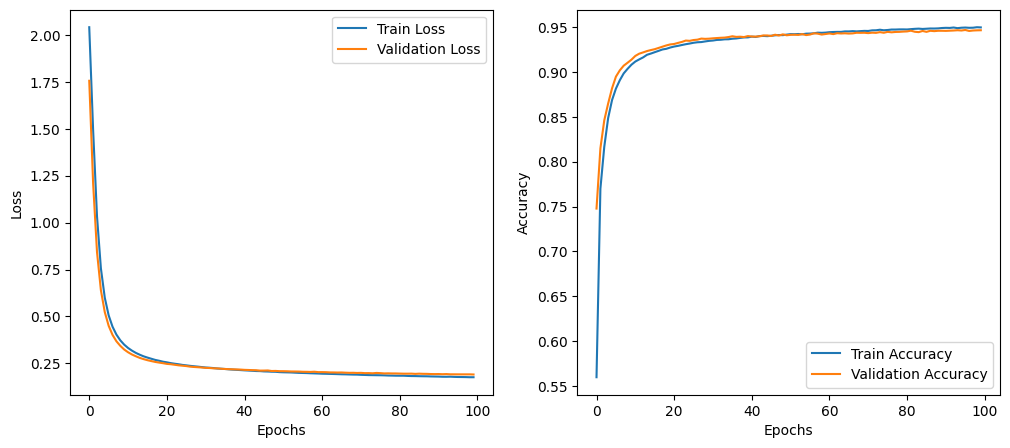

In [15]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Fast Kan


## Model

In [23]:
class SplineLinear(nn.Linear):
    def __init__(self, in_features: int, out_features: int, init_scale: float = 0.1, **kw) -> None:
        self.init_scale = init_scale
        super().__init__(in_features, out_features, bias=False, **kw)

    def reset_parameters(self) -> None:
        nn.init.trunc_normal_(self.weight, mean=0, std=self.init_scale)

class RadialBasisFunction(nn.Module):
    def __init__(
        self,
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        denominator: float = None,  # larger denominators lead to smoother basis
    ):
        super().__init__()
        self.grid_min = grid_min
        self.grid_max = grid_max
        self.num_grids = num_grids
        grid = torch.linspace(grid_min, grid_max, num_grids)
        self.grid = torch.nn.Parameter(grid, requires_grad=False)
        self.denominator = denominator or (grid_max - grid_min) / (num_grids - 1)

    def forward(self, x):
        return torch.exp(-((x[..., None] - self.grid) / self.denominator) ** 2)

class FastKANLayer(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        use_base_update: bool = True,
        use_layernorm: bool = True,
        base_activation = F.silu,
        spline_weight_init_scale: float = 0.1,
    ) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layernorm = None
        if use_layernorm:
            assert input_dim > 1, "Do not use layernorms on 1D inputs. Set `use_layernorm=False`."
            self.layernorm = nn.LayerNorm(input_dim)
        self.rbf = RadialBasisFunction(grid_min, grid_max, num_grids)
        self.spline_linear = SplineLinear(input_dim * num_grids, output_dim, spline_weight_init_scale)
        self.use_base_update = use_base_update
        if use_base_update:
            self.base_activation = base_activation
            self.base_linear = nn.Linear(input_dim, output_dim)

    def forward(self, x, use_layernorm=True):
        if self.layernorm is not None and use_layernorm:
            spline_basis = self.rbf(self.layernorm(x))
        else:
            spline_basis = self.rbf(x)
        ret = self.spline_linear(spline_basis.view(*spline_basis.shape[:-2], -1))
        if self.use_base_update:
            base = self.base_linear(self.base_activation(x))
            ret = ret + base
        return ret

    def plot_curve(
        self,
        input_index: int,
        output_index: int,
        num_pts: int = 1000,
        num_extrapolate_bins: int = 2
    ):
        '''this function returns the learned curves in a FastKANLayer.
        input_index: the selected index of the input, in [0, input_dim) .
        output_index: the selected index of the output, in [0, output_dim) .
        num_pts: num of points sampled for the curve.
        num_extrapolate_bins (N_e): num of bins extrapolating from the given grids. The curve
            will be calculate in the range of [grid_min - h * N_e, grid_max + h * N_e].
        '''
        ng = self.rbf.num_grids
        h = self.rbf.denominator
        assert input_index < self.input_dim
        assert output_index < self.output_dim
        w = self.spline_linear.weight[
            output_index, input_index * ng : (input_index + 1) * ng
        ]   # num_grids,
        x = torch.linspace(
            self.rbf.grid_min - num_extrapolate_bins * h,
            self.rbf.grid_max + num_extrapolate_bins * h,
            num_pts
        )   # num_pts, num_grids
        with torch.no_grad():
            y = (w * self.rbf(x.to(w.dtype))).sum(-1)
        return x, y


class FastKAN(nn.Module):
    def __init__(
        self,
        layers_hidden: List[int],
        grid_min: float = -1.,
        grid_max: float = 1.,
        num_grids: int = 5,
        use_base_update: bool = True,
        base_activation = F.silu,
        spline_weight_init_scale: float = 0.1,
    ) -> None:
        super().__init__()
        self.layers = nn.ModuleList([
            FastKANLayer(
                in_dim, out_dim,
                grid_min=grid_min,
                grid_max=grid_max,
                num_grids=num_grids,
                use_base_update=use_base_update,
                base_activation=base_activation,
                spline_weight_init_scale=spline_weight_init_scale,
            ) for in_dim, out_dim in zip(layers_hidden[:-1], layers_hidden[1:])
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class AttentionWithFastKANTransform(nn.Module):

    def __init__(
        self,
        q_dim: int,
        k_dim: int,
        v_dim: int,
        head_dim: int,
        num_heads: int,
        gating: bool = True,
    ):
        super(AttentionWithFastKANTransform, self).__init__()

        self.num_heads = num_heads
        total_dim = head_dim * self.num_heads
        self.gating = gating
        self.linear_q = FastKANLayer(q_dim, total_dim)
        self.linear_k = FastKANLayer(k_dim, total_dim)
        self.linear_v = FastKANLayer(v_dim, total_dim)
        self.linear_o = FastKANLayer(total_dim, q_dim)
        self.linear_g = None
        if self.gating:
            self.linear_g = FastKANLayer(q_dim, total_dim)
        # precompute the 1/sqrt(head_dim)
        self.norm = head_dim**-0.5

    def forward(
        self,
        q: torch.Tensor,
        k: torch.Tensor,
        v: torch.Tensor,
        bias: torch.Tensor = None,      # additive attention bias
    ) -> torch.Tensor:

        wq = self.linear_q(q).view(*q.shape[:-1], 1, self.num_heads, -1) * self.norm     # *q1hc
        wk = self.linear_k(k).view(*k.shape[:-2], 1, k.shape[-2], self.num_heads, -1)    # *1khc
        att = (wq * wk).sum(-1).softmax(-2)     # *qkh
        del wq, wk
        if bias is not None:
            att = att + bias[..., None]

        wv = self.linear_v(v).view(*v.shape[:-2],1, v.shape[-2], self.num_heads, -1)     # *1khc
        o = (att[..., None] * wv).sum(-3)        # *qhc
        del att, wv

        o = o.view(*o.shape[:-2], -1)           # *q(hc)

        if self.linear_g is not None:
            # gating, use raw query input
            g = self.linear_g(q)
            o = torch.sigmoid(g) * o

        # merge heads
        o = self.linear_o(o)
        return o

## Train

In [ ]:
IMG_SIZE = 14

# Load MNIST
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Resize((IMG_SIZE, IMG_SIZE))]
)
trainset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
valset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
trainloader = DataLoader(trainset, batch_size=1024, shuffle=True)
valloader = DataLoader(valset, batch_size=1024 * 16, shuffle=False)

# Define model
model = FastKAN([IMG_SIZE ** 2, 10])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

# Define loss
criterion = nn.CrossEntropyLoss()

# Lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(100):
    # Train
    model.train()
    running_loss = 0
    running_accuracy = 0
    with tqdm(trainloader) as pbar:
        for i, (images, labels) in enumerate(pbar):
            images = images.view(-1, IMG_SIZE**2 ).to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels.to(device))
            loss.backward()
            optimizer.step()
            accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
            running_loss += loss.item()
            running_accuracy += accuracy.item()
            pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])

    train_loss = running_loss / len(trainloader)
    train_accuracy = running_accuracy / len(trainloader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for images, labels in valloader:
            images = images.view(-1, IMG_SIZE**2).to(device)
            output = model(images)
            val_loss += criterion(output, labels.to(device)).item()
            val_accuracy += (
                (output.argmax(dim=1) == labels.to(device)).float().mean().item()
            )
    val_loss /= len(valloader)
    val_accuracy /= len(valloader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Update learning rate
    scheduler.step(val_loss)

    print(
        f"Epoch {epoch + 1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}"
    )



100%|██████████| 59/59 [00:13<00:00,  4.49it/s, accuracy=0.766, loss=0.955, lr=0.001]


Epoch 1, Train Loss: 1.6194245481895189, Train Accuracy: 0.4945352572505757, Val Loss: 0.984501838684082, Val Accuracy: 0.7479999661445618


100%|██████████| 59/59 [00:12<00:00,  4.58it/s, accuracy=0.854, loss=0.611, lr=0.001]


Epoch 2, Train Loss: 0.7805112438686823, Train Accuracy: 0.8023388719154616, Val Loss: 0.6228227615356445, Val Accuracy: 0.8445000052452087


100%|██████████| 59/59 [00:12<00:00,  4.54it/s, accuracy=0.887, loss=0.44, lr=0.001]


Epoch 3, Train Loss: 0.5619578679739419, Train Accuracy: 0.8567397624759351, Val Loss: 0.49110621213912964, Val Accuracy: 0.877299964427948


100%|██████████| 59/59 [00:13<00:00,  4.47it/s, accuracy=0.883, loss=0.424, lr=0.001]


Epoch 4, Train Loss: 0.46645207980931813, Train Accuracy: 0.8789628754227848, Val Loss: 0.4207025468349457, Val Accuracy: 0.8928999900817871


100%|██████████| 59/59 [00:13<00:00,  4.43it/s, accuracy=0.905, loss=0.358, lr=0.001]


Epoch 5, Train Loss: 0.4106197235947948, Train Accuracy: 0.8911598880412215, Val Loss: 0.37741461396217346, Val Accuracy: 0.9006999731063843


100%|██████████| 59/59 [00:13<00:00,  4.52it/s, accuracy=0.9, loss=0.364, lr=0.001]


Epoch 6, Train Loss: 0.3737953734599938, Train Accuracy: 0.8987563424191233, Val Loss: 0.34710821509361267, Val Accuracy: 0.9071999788284302


100%|██████████| 59/59 [00:13<00:00,  4.47it/s, accuracy=0.901, loss=0.348, lr=0.001]


Epoch 7, Train Loss: 0.34635159322770975, Train Accuracy: 0.9051401514118, Val Loss: 0.3244306445121765, Val Accuracy: 0.9120999574661255


100%|██████████| 59/59 [00:13<00:00,  4.39it/s, accuracy=0.9, loss=0.319, lr=0.001]


Epoch 8, Train Loss: 0.3252836193068553, Train Accuracy: 0.9104916443259029, Val Loss: 0.3076988160610199, Val Accuracy: 0.9159999489784241


 63%|██████▎   | 37/59 [00:08<00:06,  3.41it/s, accuracy=0.91, loss=0.335, lr=0.001]